In [1]:
import yfinance as yf
stock='AMZN'
data = yf.download(tickers=stock,period='5y',interval='1d')

data['SMA_10'] = data['Close'].rolling(window=10).mean()
data.tail()
data.head()
# print(len(data))

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,SMA_10
Date,,,,,,,
2017-05-31,1000.000000,1000.119995,982.159973,994.619995,994.619995,3913100,NaN
2017-06-01,998.590027,998.989990,991.369995,995.950012,995.950012,2454800,NaN
2017-06-02,998.989990,1008.479980,995.669983,1006.729980,1006.729980,3752300,NaN
2017-06-05,1007.229980,1013.210022,1003.510010,1011.340027,1011.340027,2719900,NaN
2017-06-06,1012.000000,1016.500000,1001.250000,1003.000000,1003.000000,3346400,NaN


<AxesSubplot:xlabel='Date'>

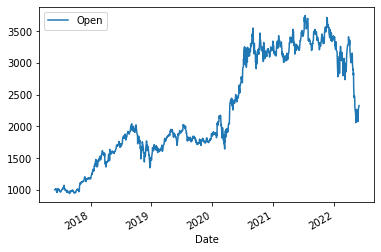

In [2]:
open_data=data[['Open']]
open_data.plot()


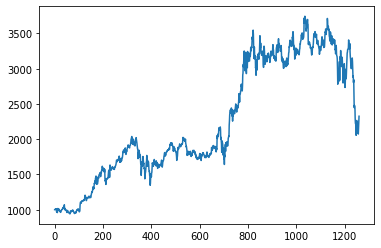

In [3]:
import matplotlib.pyplot as plt
ds = open_data.values
plt.plot(ds)

In [4]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))
len(ds_scaled), len(ds)
ds_scaled

array([[0.021398  ],
       [0.02089516],
       [0.0210378 ],
       ...,
       [0.43487871],
       [0.47467903],
       [0.49415125]])

In [5]:
train_size = int(len(ds_scaled)*0.70)
test_size = len(ds_scaled) - train_size
train_size,test_size

(882, 378)

In [6]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]
len(ds_train),len(ds_test)

(882, 378)

In [7]:
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)


time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [8]:
X_train.shape,y_train.shape
X_test.shape, y_test.shape

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [9]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
13/13 [==============================] - 14s 399ms/step - loss: 0.0408 - val_loss: 0.0792
Epoch 2/100
13/13 [==============================] - 3s 208ms/step - loss: 0.0092 - val_loss: 0.0077
Epoch 3/100
13/13 [==============================] - 3s 198ms/step - loss: 0.0036 - val_loss: 0.0100
Epoch 4/100
13/13 [==============================] - 2s 188ms/step - loss: 0.0020 - val_loss: 0.0074
Epoch 5/100
13/13 [==============================] - 2s 189ms/step - loss: 0.0018 - val_loss: 0.0058
Epoch 6/100
13/13 [==============================] - 2s 191ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 7/100
13/13 [==============================] - 2s 192ms/step - loss: 0.0016 - val_loss: 0.0061
Epoch 8/100
13/13 [==============================] - 2s 193ms/step - loss: 0.0016 - val_loss: 0.0057
Epoch 9/100
13/13 [==============================] - 3s 194ms/step - loss: 0.0016 - val_loss: 0.0055
Epoch 10/100
13/13 [==============================] - 3s 195ms/step - loss: 0.0016 - val_l

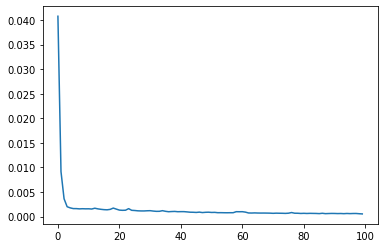

In [11]:
 loss = model.history.history['loss']
 plt.plot(loss)

In [12]:
len(ds_test)
fut_inp=ds_test[278:]
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)
print(type(tmp_inp))
fut_inp.shape
tmp_inp = tmp_inp[0].tolist()
type(tmp_inp)

<class 'list'>


list

In [13]:
lst_output=[]
n_steps=100
i=0
while(i<15):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[[0.4619676470756531], [0.47287893295288086], [0.48189714550971985], [0.4891413152217865], [0.4950307309627533], [0.49990424513816833], [0.5039737820625305], [0.5073695778846741], [0.5101860165596008], [0.5125114321708679], [0.5144351720809937], [0.5160517692565918], [0.5174548029899597], [0.5187334418296814], [0.5199680328369141]]


In [14]:
ds_new = ds_scaled.tolist()
ds_new.extend(lst_output)
# plt.plot(ds_new[1200:])
final_graph = normalizer.inverse_transform(ds_new).tolist()

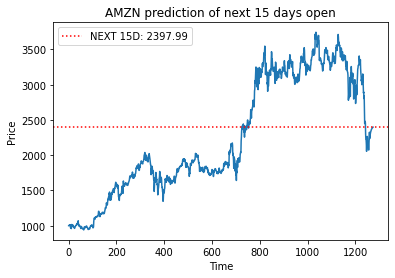

In [15]:

plt.plot(final_graph,)

plt.ylabel("Price")
plt.xlabel("Time")

plt.title("{0} prediction of next 15 days open".format(stock))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 15D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()

<AxesSubplot:xlabel='Date'>

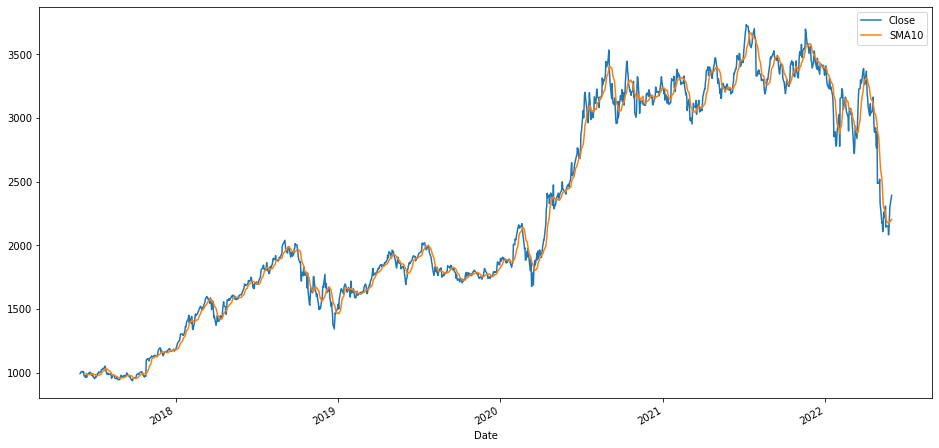

In [16]:
amazon_avg = data['Close'].to_frame()
amazon_avg['SMA10'] =amazon_avg['Close'].rolling(10).mean()
amazon_avg[['Close', 'SMA10']].plot(label='AMAZON', 
                                  figsize=(16, 8))

In [20]:
stock_amazon = yf.Ticker('AMZN')
stock_amazon.options
option_chain = stock_amazon.option_chain(date='2022-06-24')
option_chain.calls.sort_values('lastTradeDate')

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
26,AMZN220624C02130000,2022-05-23 17:41:46+00:00,2130.0,117.00,295.55,301.95,0.00000,0.00000,2.0,2,0.518521,True,REGULAR,USD
25,AMZN220624C02125000,2022-05-23 18:44:47+00:00,2125.0,148.18,297.65,305.50,0.00000,0.00000,4.0,3,0.511388,True,REGULAR,USD
118,AMZN220624C02940000,2022-05-24 14:18:13+00:00,2940.0,4.15,5.20,6.15,2.24000,117.27751,1.0,2,0.464544,False,REGULAR,USD
37,AMZN220624C02185000,2022-05-24 14:38:53+00:00,2185.0,69.97,251.30,255.40,0.00000,0.00000,11.0,4,0.510121,True,REGULAR,USD
21,AMZN220624C02105000,2022-05-24 15:06:04+00:00,2105.0,113.36,316.55,322.40,0.00000,0.00000,2.0,5,0.523328,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,AMZN220624C03250000,2022-05-31 16:52:45+00:00,3250.0,2.21,1.72,2.66,1.00000,82.64462,2.0,110,0.540593,False,REGULAR,USD
64,AMZN220624C02360000,2022-05-31 16:54:17+00:00,2360.0,134.15,133.25,136.15,60.16999,81.33278,12.0,25,0.472326,True,REGULAR,USD
60,AMZN220624C02300000,2022-05-31 16:54:17+00:00,2300.0,169.00,168.70,171.80,65.00000,62.50000,24.0,238,0.479787,True,REGULAR,USD
92,AMZN220624C02500000,2022-05-31 16:55:40+00:00,2500.0,66.50,67.10,68.90,30.00000,82.19178,206.0,140,0.443754,False,REGULAR,USD


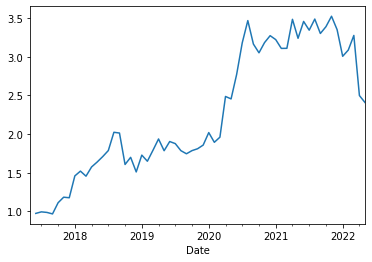

In [21]:
import pandas as pd
import pandas_datareader as web
import yfinance as yf


amazon_data = web.get_data_yahoo('AMZN',)
amazon_stock_daily_returns = amazon_data['Adj Close'].pct_change()
amazon_stock_monthly_returns = amazon_data['Adj Close'].resample('M').ffill().pct_change()
fig = plt.figure()
(amazon_stock_monthly_returns + 1).cumprod().plot()
plt.show()

<Figure size 432x288 with 0 Axes>

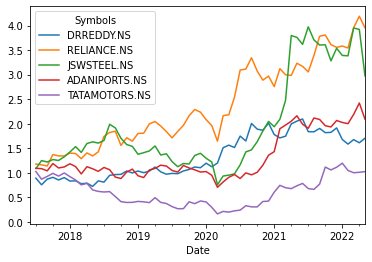

In [22]:
import pandas as pd
import pandas_datareader as web
import yfinance as yf
nifty5=['DRREDDY.NS','RELIANCE.NS','JSWSTEEL.NS','ADANIPORTS.NS','TATAMOTORS.NS']
multpl_stocks = web.get_data_yahoo(nifty5,)
multpl_stock_daily_returns = multpl_stocks['Adj Close'].pct_change()
multpl_stock_monthly_returns = multpl_stocks['Adj Close'].resample('M').ffill().pct_change()
fig = plt.figure()
(multpl_stock_monthly_returns + 1).cumprod().plot()
plt.show()

Text(50, 50, 'VaR of Amazon')

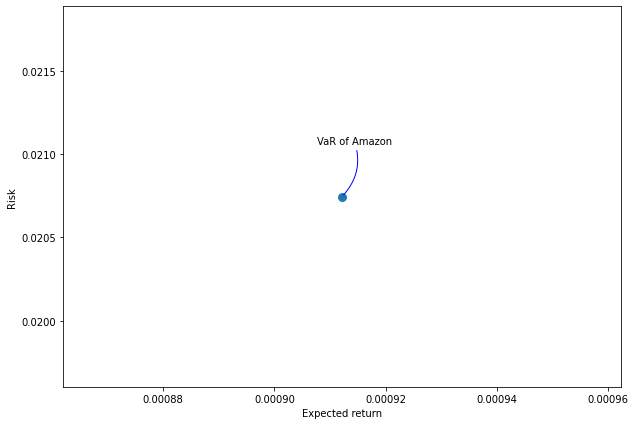

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader

closing_df = data['Adj Close']
# closing_df.head()
tech_rets = closing_df.pct_change()
tech_rets.head()


rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 7))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

plt.annotate("VaR of Amazon", xy=(rets.mean(), rets.std()),xytext=(50, 50),textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

In [25]:
import pandas_ta as ta
import matplotlib.pyplot as plt
import pandas as pd

macd = ta.macd(data['Close'])
data = pd.concat([data, macd], axis=1).reindex(data.index)
# data=data.drop(['MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9','MACD_Buy_Signal_price','MACD_Sell_Signal_price'])
# data

In [26]:
def MACD_Strategy(df, risk):
    MACD_Buy=[]
    MACD_Sell=[]
    position=False

    for i in range(0, len(df)):
        if df['MACD_12_26_9'][i] > df['MACDs_12_26_9'][i] :
            MACD_Sell.append(np.nan)
            if position ==False:
                MACD_Buy.append(df['Adj Close'][i])
                position=True
            else:
                MACD_Buy.append(np.nan)
        elif df['MACD_12_26_9'][i] < df['MACDs_12_26_9'][i] :
            MACD_Buy.append(np.nan)
            if position == True:
                MACD_Sell.append(df['Adj Close'][i])
                position=False
            else:
                MACD_Sell.append(np.nan)
        elif position == True and df['Adj Close'][i] < MACD_Buy[-1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        elif position == True and df['Adj Close'][i] < df['Adj Close'][i - 1] * (1 - risk):
            MACD_Sell.append(df["Adj Close"][i])
            MACD_Buy.append(np.nan)
            position = False
        else:
            MACD_Buy.append(np.nan)
            MACD_Sell.append(np.nan)

    data['MACD_Buy_Signal_price'] = MACD_Buy
    data['MACD_Sell_Signal_price'] = MACD_Sell


MACD_strategy = MACD_Strategy(data, 0.025)
data

,Open,High,Low,Close,Adj Close,Volume,SMA_10,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,MACD_Buy_Signal_price,MACD_Sell_Signal_price
Date,,,,,,,,,,,,
2017-05-31,1000.000000,1000.119995,982.159973,994.619995,994.619995,3913100,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-01,998.590027,998.989990,991.369995,995.950012,995.950012,2454800,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-02,998.989990,1008.479980,995.669983,1006.729980,1006.729980,3752300,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-05,1007.229980,1013.210022,1003.510010,1011.340027,1011.340027,2719900,NaN,NaN,NaN,NaN,NaN,NaN
2017-06-06,1012.000000,1016.500000,1001.250000,1003.000000,1003.000000,3346400,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-24,2080.500000,2108.000000,2025.199951,2082.000000,2082.000000,5146700,2170.432007,-201.387199,7.851487,-209.238686,NaN,NaN
2022-05-25,2073.110107,2163.500000,2073.000000,2135.500000,2135.500000,4656000,2173.238013,-193.228790,12.807917,-206.036707,NaN,NaN
2022-05-26,2159.399902,2253.310059,2149.070068,2221.550049,2221.550049,4650100,2181.532007,-177.770445,22.613010,-200.383455,NaN,NaN


Text(0.5, 0, 'Date')

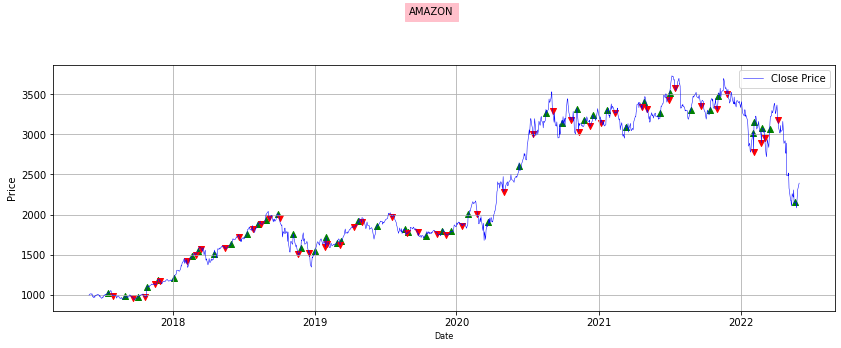

In [27]:
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle('AMAZON', fontsize=10, backgroundcolor='pink', color='black')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax1.set_ylabel('Price')
ax1.plot('Adj Close',data=data, label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(data.index, data['MACD_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(data.index, data['MACD_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)